In [291]:
%pylab inline
import numpy as np
import pandas as pd

import sys; sys.path.append("../")
import metrics

import pickle
import seaborn as sns
sns.set_style('whitegrid')
from tqdm import tqdm_notebook as tqdm

from glob import glob
from importlib import reload
import util
reload(util)

Populating the interactive namespace from numpy and matplotlib


/data/jonas/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<module 'util' from '../util.py'>

In [292]:
# mean spectrum
spect_df = []
for nuc in ['1H', '13C']:
    
    spect_filename = f'../dataset.named/spectra.nmrshiftdb_{nuc}.feather'
    a = pd.read_feather(spect_filename)
    a['nuc'] = nuc
    spect_df.append(a)
spect_df = pd.concat(spect_df)
spect_agg_df = spect_df.groupby(['molecule_id', 'atom_idx']).agg({'value' : 'median'})
spect_agg_df.head()

value
molecule_id atom_idx       
4001        0          18.3
            1          41.8
            2          33.5
            3          42.2
            4          42.0

# clean hose data

In [293]:
# clean up and sort hose data
hose_preds_df = pd.read_feather("../hose/hose_preds_df.feather")
### FIXME

del hose_preds_df['id']
del hose_preds_df['value']
del hose_preds_df['delta']
del hose_preds_df['delta_abs'] # .groupby(["mol_id", 'atom_idx'])
hose_preds_df = hose_preds_df.join(spect_agg_df, on =['mol_id', 'atom_idx'])

print("WARNING WHY DO WE HAVE NANS IN HOSE_PREDS")
print(len(hose_preds_df))
print(len(hose_preds_df.dropna()))
hose_preds_df = hose_preds_df.dropna()

hose_preds_df['delta'] = hose_preds_df.value - hose_preds_df.pred
hose_preds_df['delta_abs'] = np.abs(hose_preds_df.delta)
hose_preds_df['delta_sq'] = np.abs(hose_preds_df.delta**2)

a = []


for nuc, df_nuc in hose_preds_df.groupby('nuc', as_index=False):
    df_nuc = df_nuc.copy()
    for sphere_min in [1, 2, 3, 4, 5, 6]:
        b = df_nuc[df_nuc.sphere_no >= sphere_min].copy()
        b['sphere_min'] = sphere_min
        a.append(b)
a = pd.concat(a)
hose_sphere_scores_df  = a.groupby(['nuc', 'sphere_min']).apply(metrics.compute_stats, 
                                                                mol_id_field='mol_id').reset_index()


WARNING WHY DO WE HAVE NANS IN HOSE_PREDS
341139
339835


In [294]:
hose_sphere_scores_df['total_atom_n'] = 0
hose_sphere_scores_df.loc[hose_sphere_scores_df.nuc == '13C', 
                          'total_atom_n'] = len(hose_preds_df[hose_preds_df.nuc == '13C'])

hose_sphere_scores_df.loc[hose_sphere_scores_df.nuc == '1H', 
                          'total_atom_n'] = len(hose_preds_df[hose_preds_df.nuc == '1H'])

hose_sphere_scores_df['nuc_frac'] = hose_sphere_scores_df.n / hose_sphere_scores_df.total_atom_n

# neural net data

In [295]:
all_df = []
for filename in glob("../preds/1H_good_cv?.feather.200"):
    df = pd.read_feather(filename)
    df['filename'] = filename
    all_df.append(df)

for filename in glob("../preds/13C_good_cv?.feather.300"):
    print('reading', filename)
    df = pd.read_feather(filename)
    df['filename'] = filename
    
    print('has', len(df[df.phase == 'test'].molecule_id.unique()), 'unique mols')
    all_df.append(df)
        
    
nn_results_df = pd.concat(all_df)
nn_results_df = nn_results_df[nn_results_df.phase == 'test'].copy()

nn_results_df = nn_results_df.drop_duplicates(subset=['molecule_id', 'atom_idx'])

del nn_results_df['value']
nn_results_df = nn_results_df.join(spect_agg_df, on =['molecule_id', 'atom_idx'])

nn_results_df['delta'] = nn_results_df.value - nn_results_df.pred_mu
nn_results_df['delta_abs'] = np.abs(nn_results_df.delta)
nn_results_df['delta_sq'] = np.abs(nn_results_df.delta**2)


reading ../preds/13C_good_cv0.feather.300
has 5055 unique mols
reading ../preds/13C_good_cv2.feather.300
has 5068 unique mols
reading ../preds/13C_good_cv1.feather.300
has 5013 unique mols
reading ../preds/13C_good_cv4.feather.300
has 5052 unique mols
reading ../preds/13C_good_cv3.feather.300
has 5072 unique mols


In [296]:
reload(metrics)
nn_fracs = []
BIN_N = 50
for nuc in ['13C', '1H']:
    a = nn_results_df[nn_results_df.nuc == nuc]
    a = a[a.phase == 'test']
    #a = a.sort_values('pred_std')
    
    #tholds = [a.pred_std.iloc[int(i*len(a))] for i in np.linspace(0.0, 1.0, BIN_N, endpoint=False)[1:]]

    #m = [np.mean(a[a.pred_std <= tholds[i]].delta_abs) for i in range(BIN_N-1)]

    #frac_data = np.linspace(0.0, 1.0, len(m))
    m, tholds, frac_data = metrics.sorted_bin_mean(a.pred_std,
                                                a.delta_abs,BIN_N)
    

    nn_fracs.append(pd.DataFrame({'mean_abs' : m, 'frac' : frac_data, 'nuc' : nuc}))
nn_fracs_df = pd.concat(nn_fracs)

# plot both

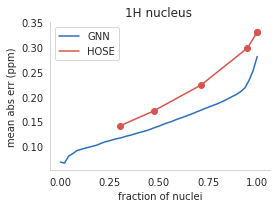

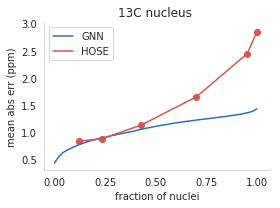

In [297]:
reload(metrics)

for nuc in ['1H', '13C']:

    fig = pylab.figure(figsize=(4, 3))
    ax = fig.add_subplot(1, 1, 1)
    a = nn_fracs_df[nn_fracs_df.nuc == nuc]
    ax.plot(a.frac, a.mean_abs, label='GNN', c=sns.xkcd_rgb["medium blue"])


    b = hose_sphere_scores_df[hose_sphere_scores_df.nuc == nuc]
    ax.plot(b.nuc_frac, b.mean_abs, c=sns.xkcd_rgb["pale red"], label='HOSE')
    ax.scatter(b.nuc_frac, b.mean_abs, c=sns.xkcd_rgb["pale red"], label=None)
    ax.set_title(f'{nuc} nucleus ')
    ax.set_ylabel("mean abs err (ppm)")
    ax.set_xlabel("fraction of nuclei")
    ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
    sns.despine()
    ax.grid(False)
    pylab.legend()
    fig.tight_layout()
    fig.savefig(f"compare results.nn_vs_hose_frac.{nuc}.pdf")

In [298]:
tgt_fracs = [1.0, 0.95, 0.80, 0.50, 0.25, 0.1]
res = []
for tgt_frac in tgt_fracs:
    for nuc in ['13C', '1H']:
        a = hose_sphere_scores_df[hose_sphere_scores_df.nuc == nuc]
        a = a[a.nuc_frac <= tgt_frac]
        a = a.sort_values('nuc_frac', ascending=False)
        if len(a) > 0:
            b = a.iloc[0]
            res.append({'nuc' : nuc, 'tgt_frac' : tgt_frac, 
                        'true_frac' : b.nuc_frac, 
                        'method' : 'HOSE',
                        'mean_abs' : b.mean_abs})
        a = nn_fracs_df[nn_fracs_df.nuc == nuc]
        a = a[a.frac <= tgt_frac]
        a = a.sort_values('frac', ascending=False)
        if len(a) > 0:
            b = a.iloc[0]
            res.append({'nuc' : nuc, 'tgt_frac' : tgt_frac, 
                        'true_frac' : b.frac, 
                        'method' : 'GNN',
                        'mean_abs' : b.mean_abs})
close_frac_df = pd.DataFrame(res)
close_frac_df.head()

,mean_abs,method,nuc,tgt_frac,true_frac
0,2.851290,HOSE,13C,1.00,0.999357
1,1.431834,GNN,13C,1.00,1.000000
2,0.330891,HOSE,1H,1.00,0.999988
3,0.281067,GNN,1H,1.00,1.000000
4,1.650755,HOSE,13C,0.95,0.700142


In [195]:
for gi, g in close_frac_df.sort_values('tgt_frac',ascending=False).groupby('tgt_frac', sort=False):
    val_strs = []
    for nuc_i, nuc_df in g.groupby('nuc'):
        nuc_df = nuc_df.sort_values('method', ascending=True)
        
        a =nuc_df[nuc_df.method == 'GNN']
        if len(a) > 0:
            gnn_val = a.iloc[0].mean_abs
            gnn_str = "{:0.2f}".format(gnn_val)
        else:
            gnn_str = ""
        a = nuc_df[nuc_df.method == 'HOSE']
        if len(a) > 0:
            hose_val = a.iloc[0].mean_abs
            hose_str = "{:0.2f}".format(hose_val)

        else:
            hose_str = ""
        val_strs.append(gnn_str)
        val_strs.append(hose_str)
    print("{:3.0f}\\%&".format(gi*100), "& ".join(val_strs), "\\\\")

100\%& 1.43& 2.85& 0.28& 0.33 \\
 95\%& 1.35& 1.65& 0.22& 0.22 \\
 80\%& 1.27& 1.65& 0.18& 0.22 \\
 50\%& 1.11& 1.13& 0.14& 0.17 \\
 25\%& 0.91& 0.88& 0.11&  \\
 10\%& 0.71& & 0.09&  \\


# Load Ab initio

In [324]:
!ls ../../nmrabinitio/simulate.orca/nmr/*.feather

../../nmrabinitio/simulate.orca/nmr/pop_20_300_macro_default_geom_nmr_default.shieldings.feather
../../nmrabinitio/simulate.orca/nmr/pop_20_300_macro_default_geom_nmr_default.shieldings_raw.feather
../../nmrabinitio/simulate.orca/nmr/pop_20_300_macro_default_geom_nmr_default.shifts.feather
../../nmrabinitio/simulate.orca/nmr/pop_20_300_macro_gaussian_tantillo1_geom_nmr_default_debug.shieldings.feather
../../nmrabinitio/simulate.orca/nmr/pop_20_300_macro_gaussian_tantillo1_geom_nmr_default_debug.shieldings_raw.feather
../../nmrabinitio/simulate.orca/nmr/pop_20_300_macro_gaussian_tantillo1_geom_nmr_default.shieldings.feather
../../nmrabinitio/simulate.orca/nmr/pop_20_300_macro_gaussian_tantillo1_geom_nmr_default.shieldings_raw.feather
../../nmrabinitio/simulate.orca/nmr/pop_20_300_macro_tantillo1_geom_nmr_default.shifts.feather


In [325]:
#nmrab_results_raw_df = pd.read_feather("../../nmrabinitio/simulate.gaussian/nmr/pop_32_300_HCON_macro_tantillo1_geom_nmr.shifts.feather")
# nmrab_results_raw_df = pd.read_feather("../../nmrabinitio/simulate.gaussian/nmr/pop_20_300_macro_tantillo1_geom_nmr.shifts.feather")
#nmrab_results_raw_df = pd.read_feather("../../nmrabinitio/simulate.qchem/nmr/pop_20_300_macro_tantillo1_geom_nmr_default.shifts.feather")
# nmrab_results_raw_df = pd.read_feather("../../nmrabinitio/simulate.qchem/nmr/pop_20_300_macro_tantillo1_geom_nmr_default2.shifts.feather")
#
nmrab_results_raw_df = pd.read_feather("../../nmrabinitio/simulate.orca/nmr/pop_20_300_macro_default_geom_nmr_default.shifts.feather")


print("total ab molecules:", len(nmrab_results_raw_df.mol_id.unique()))
# do a little cleanup:


nmrab_results_df = nmrab_results_raw_df[['mol_id', 'atom_idx',  'pred', 'element']].drop_duplicates(subset=['mol_id', 'atom_idx']).copy()

nmrab_results_df = nmrab_results_df.join(spect_agg_df, on =['mol_id', 'atom_idx'])


nmrab_results_df['nuc'] = nmrab_results_df.element.apply(lambda x: '13C' if x =='C' else  '1H')


nmrab_results_df['delta'] = nmrab_results_df.value - nmrab_results_df.pred
nmrab_results_df['delta_abs'] = np.abs(nmrab_results_df.delta)
nmrab_results_df['delta_sq'] = np.abs(nmrab_results_df.delta**2)



total ab molecules: 175


# Combine data

In [326]:
# Combine
a = nmrab_results_df.copy()
del a['element']
a['method'] = 'abinitio'

b = hose_preds_df.copy()
del b['sphere_no']
#del b['id']
del b['filename']
b = b.dropna()
b['mol_id'] = b.mol_id.astype(int)
b['method'] ='hose'

c = nn_results_df[nn_results_df.phase == 'test'].copy()
c['pred'] = c['pred_mu']
c['mol_id'] = c['molecule_id']
for f in ['m_pos', 'nuc_i', 'pred_mu', 'pred_std', 'molecule_id', 'phase', 'epoch_i', 'delta_sq']:
    del c[f]
c['method'] = 'gnn'

all_pred_df = pd.concat([a, b, c], sort=False)
common_mols = set(a.mol_id).intersection(set(b.mol_id).intersection(set(c.mol_id)))
all_pred_common_df = all_pred_df[all_pred_df.mol_id.isin(common_mols)]
print("There are", len(common_mols), "common_mols")

There are 175 common_mols


In [327]:
### Save results for supplementary material
a = all_pred_common_df.reset_index()
del a['index']
a.to_feather("../methods_compare_results.all_pred_common_df.feather")

In [328]:
compare_nums_df = all_pred_common_df.groupby(['nuc', 'method']).apply(metrics.compute_stats, 
                                                                    mol_id_field='mol_id')
compare_nums_df

mol_MAE   mol_MSE  mean_abs       std      n  mol_n
nuc method                                                        
13C abinitio  2.265089  2.762774  1.943372  3.121983  980.0  174.0
    gnn       1.004815  1.191618  0.967933  1.509023  980.0  174.0
    hose      3.442966  4.258602  2.574010  5.040565  987.0  174.0
1H  abinitio  0.385553  0.559318  0.368682  0.911957  991.0  167.0
    gnn       0.298989  0.402990  0.287234  0.655112  991.0  167.0
    hose      0.452791  0.592058  0.420000  0.851683  991.0  167.0

In [99]:
for row_i, row in compare_nums_df.reset_index().iterrows():
    s = f"{row.nuc} & {row.method} & {row.mol_MAE:3.2f} & {row.mol_MSE:3.2f} & {row.mean_abs:3.2f}\\\\"
    print(s)

13C & abinitio & 2.24 & 2.73 & 1.92\\
13C & gnn & 1.01 & 1.20 & 0.97\\
13C & hose & 3.42 & 4.24 & 2.56\\
1H & abinitio & 0.39 & 0.57 & 0.37\\
1H & gnn & 0.30 & 0.40 & 0.29\\
1H & hose & 0.45 & 0.59 & 0.42\\


/data/jonas/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


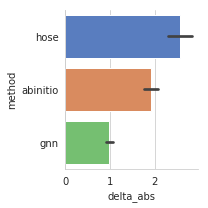

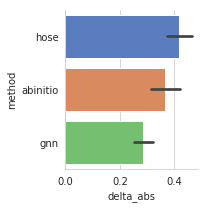

In [220]:

for nuc, g in all_pred_common_df.groupby('nuc'):
    g = sns.catplot(y='method', x='delta_abs', orient='h',
        data=g, kind="bar", palette="muted", #ci='sd',
        order=['hose', 'abinitio', 'gnn'], # , aspect=nuc_aspect[nuc], height=2)
              height=3 )
    g.savefig(f"methods_compare_results.all.{nuc}.MAE.pdf")

/data/jonas/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


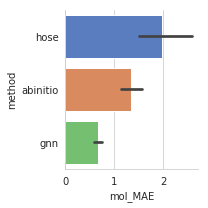

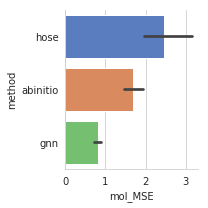

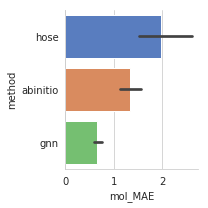

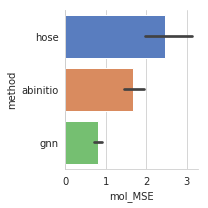

In [216]:
per_mol_compare_df = []
for ((nuc, method), g) in  all_pred_common_df.groupby(['nuc', 'method']):
    _, s = metrics.compute_stats(g, mol_id_field='mol_id', return_per_mol=True)
    s['nuc'] = nuc
    s['method'] = method
    per_mol_compare_df.append(s)
per_mol_compare_df = pd.concat(per_mol_compare_df)
per_mol_compare_df

for nuc in ['13C', '1H']:
    for metric in ['mol_MAE', 'mol_MSE']:
        g = sns.catplot(y='method', x=metric, orient='h',
            data=per_mol_compare_df, kind="bar", palette="muted", #ci='sd',
            order=['hose', 'abinitio', 'gnn'], # , aspect=nuc_aspect[nuc], height=2)
                  height=3 )
        g.savefig(f"methods_compare_results.all.{nuc}.{metric}.pdf")

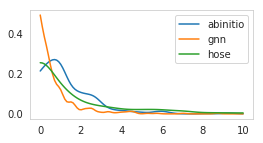

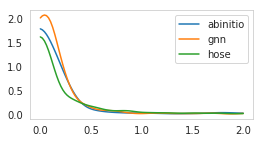

In [72]:
import scipy.stats
nuc_bins = {'13C' : np.linspace(0, 10, 100), 
       '1H' : np.linspace(0, 2, 100)}
nuc_bw = {'13C' : 0.1, '1H' : 0.1}

for nuc, nuc_g in all_pred_common_df.groupby('nuc'):
    fig = pylab.figure(figsize=(4, 2))
    ax =fig.add_subplot(1, 1, 1)
    bins = nuc_bins[nuc]
    for method, method_g in nuc_g.groupby('method'):
        k = scipy.stats.gaussian_kde(method_g.delta, bw_method=nuc_bw[nuc])
        pylab.plot(bins, k(bins), label=method)
        ax.grid(False)
    pylab.legend()

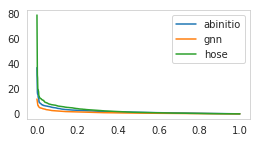

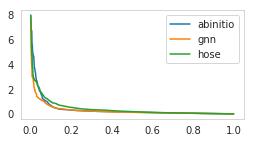

In [73]:
import scipy.stats
nuc_bins = {'13C' : np.linspace(0, 10, 20), 
       '1H' : np.linspace(0, 2, 100)}
nuc_bw = {'13C' : 0.1, '1H' : 0.1}

for nuc, nuc_g in all_pred_common_df.groupby('nuc'):
    fig = pylab.figure(figsize=(4, 2))
    ax =fig.add_subplot(1, 1, 1)
    bins = nuc_bins[nuc]
    for method, method_g in nuc_g.groupby('method'):
        y = np.sort(method_g.delta_abs)[::-1]
        x = np.arange(len(y))/len(y)
        #h, _= np.histogram(method_g.delta, bins=bins)
        pylab.plot(x, y, label=method)
        ax.grid(False)
    pylab.legend()

/data/jonas/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


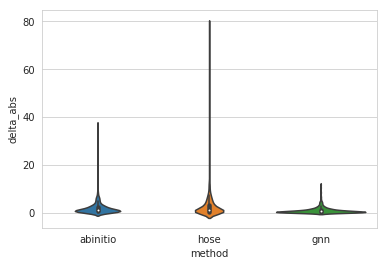

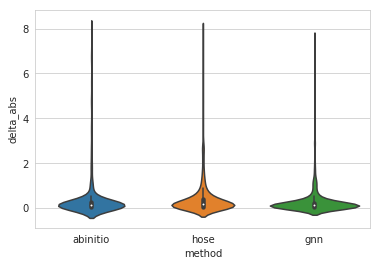

In [74]:
for nuc, nuc_g in all_pred_common_df.groupby('nuc'):
    pylab.figure()
    sns.violinplot(x='method', y='delta_abs', data=nuc_g)

# which atoms in molecule

In [75]:
mol_df = pickle.load(open("../dataset.named/molconf.nmrshiftdb_hconfspcl_nmrshiftdb.pickle", 'rb'))['df']
neighbors_df = util.mol_df_to_neighbor_atoms(mol_df)


100%|██████████| 34974/34974 [00:08<00:00, 4362.12it/s]


In [76]:
a = all_pred_common_df.join(neighbors_df, on=['mol_id', 'atom_idx'])
cat_df = []
for e in ['H', 'C', 'O', 'Cl', 'F', 'N', 'S', 'P']:
    b = a[a[e] > 0].copy()
    b['bond'] = e
    cat_df.append(b)
cat_df = pd.concat(cat_df)

/data/jonas/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


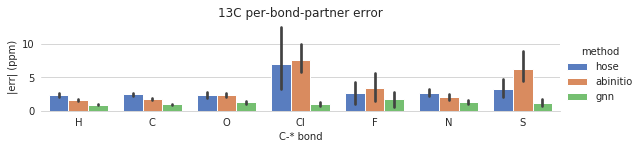

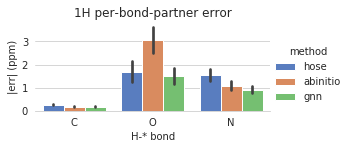

In [93]:
nuc_aspect={'13C' : 4.0, '1H':2.0}
for nuc, nuc_df in cat_df.groupby('nuc'):
    #fig = pylab.figure()
    g = sns.catplot(x='bond', y='delta_abs', hue='method',
                data=nuc_df, kind="bar", palette="muted", #ci='sd',
                    hue_order=['hose', 'abinitio', 'gnn'], aspect=nuc_aspect[nuc], height=2)
    
    g.despine(left=True)
    g.set_axis_labels("{}-* bond".format(nuc[-1]), "|err| (ppm)")
    g.ax.set_title(f"{nuc} per-bond-partner error")
    #g.fig.tight_layout()
    g.fig.savefig(f"method_compare_results.per_bond.{nuc}.pdf")

# nmr ab initio timings

In [127]:
nmr_giao_meta_df = pickle.load(open("../../nmrabinitio/simulate.gaussian/nmr/pop_20_300_macro_tantillo1_geom_nmr.meta.pickle", 'rb'))['meta_df']
nmr_geom_meta_df = pickle.load(open("../../nmrabinitio/simulate.gaussian/geom/pop_20_300_macro_tantillo1_geom.results", 'rb'))['meta_df']

geom_timing = nmr_geom_meta_df[['mol_id', 'conf_i', 'wall_time', 'cpu_time']].set_index(['mol_id', 'conf_i'])
geom_timing = geom_timing.rename(columns={'wall_time' : 'geom_wall_time', 'cpu_time' : 'cpu_wall_time'})
giao_timing = nmr_giao_meta_df[['mol_id', 'conf_i', 'wall_time', 'cpu_time']]
timing_df = giao_timing.join(geom_timing, on=['mol_id', 'conf_i'])
timing_df = timing_df.rename(columns={'wall_time' : 'giao_wall_time', 'giao_time' : 'cpu_wall_time'})
mol_df['atom_n'] = mol_df.rdmol.apply(lambda x : x.GetNumAtoms())
timing_df = timing_df.join(mol_df[['atom_n']], on='mol_id')
timing_agg_df = timing_df.groupby('mol_id').agg({'geom_wall_time' : 'sum', 'giao_wall_time' : 'sum', 'atom_n' : 'first'})
timing_agg_df.mean()

geom_wall_time    556.728814
giao_wall_time    250.386441
atom_n             15.090395
dtype: float64

In [128]:
timing_agg_df.sum()

geom_wall_time    98541.0
giao_wall_time    44318.4
atom_n             2671.0
dtype: float64

In [129]:
print("GEOM per-atom time", 98541.0/2671.0)
print("GIAO per-atom time", 44318.4/2671.0)


GEOM per-atom time 36.89292399850243
GIAO per-atom time 16.592437289404717


# metadata about compared molecules

In [226]:
all_pred_common_df.head()

,mol_id,atom_idx,pred,value,nuc,delta,delta_abs,delta_sq,method,filename
0,4700,0,13.217809,13.43,13C,0.212191,0.212191,0.045025,abinitio,NaN
2,4812,2,26.740380,27.10,13C,0.359620,0.359620,0.129326,abinitio,NaN
3,4812,5,26.740380,27.10,13C,0.359620,0.359620,0.129326,abinitio,NaN
4,4990,4,132.066913,132.20,13C,0.133087,0.133087,0.017712,abinitio,NaN
5,6789,3,112.646867,115.00,13C,2.353133,2.353133,5.537235,abinitio,NaN


In [240]:
a = all_pred_common_df.drop_duplicates(['mol_id', 'atom_idx'])
mols_by_observed_nuc = pd.DataFrame(a.groupby('mol_id').size().sort_values()).rename(columns={0 : 'nucs_observed'})

In [244]:
mols_by_observed_nuc['rdmol'] = mol_df.loc[mols_by_observed_nuc.index].rdmol

In [262]:
from rdkit import Chem
def mol_2d_clean(m):
    m = Chem.Mol(Chem.RemoveHs(m))
    Chem.AllChem.Compute2DCoords(m)
    return m
    
mols_by_observed_nuc['rdmol_plot'] = mols_by_observed_nuc.rdmol.apply(mol_2d_clean)


In [263]:
mols_by_observed_nuc['smiles'] = mols_by_observed_nuc.rdmol_plot.apply(lambda x:Chem.MolToSmiles(x))


In [264]:
mols_by_observed_nuc

,nucs_observed,rdmol,rdmol_plot,smiles
mol_id,,,,
36258,2,<rdkit.Chem.rdchem.Mol object at 0x7f792db906f8>,<rdkit.Chem.rdchem.Mol object at 0x7f78e513fa08>,O
8344,2,<rdkit.Chem.rdchem.Mol object at 0x7f78e432bc38>,<rdkit.Chem.rdchem.Mol object at 0x7f78e513f030>,ClC(Cl)Cl
7754,3,<rdkit.Chem.rdchem.Mol object at 0x7f78e4300768>,<rdkit.Chem.rdchem.Mol object at 0x7f78e513f180>,S=C1NCCS1
7982,3,<rdkit.Chem.rdchem.Mol object at 0x7f78e42f3570>,<rdkit.Chem.rdchem.Mol object at 0x7f78e513fc38>,CN(C)C=O
4823,3,<rdkit.Chem.rdchem.Mol object at 0x7f78e423bab0>,<rdkit.Chem.rdchem.Mol object at 0x7f78e513fd18>,ClCCl
7781,4,<rdkit.Chem.rdchem.Mol object at 0x7f78e42fe768>,<rdkit.Chem.rdchem.Mol object at 0x7f78e513f928>,CC(=O)N(C)C
9496,4,<rdkit.Chem.rdchem.Mol object at 0x7f78e5ed8c70>,<rdkit.Chem.rdchem.Mol object at 0x7f78e513f7d8>,C[N+](=O)[O-]
7953,4,<rdkit.Chem.rdchem.Mol object at 0x7f78e42f5340>,<rdkit.Chem.rdchem.Mol object at 0x7f78e513fe68>,O=C1CCCN1
13988,4,<rdkit.Chem.rdchem.Mol object at 0x7f78e7a29998>,<rdkit.Chem.rdchem.Mol object at 0x7f78e513fa78>,O=C1NCCN1


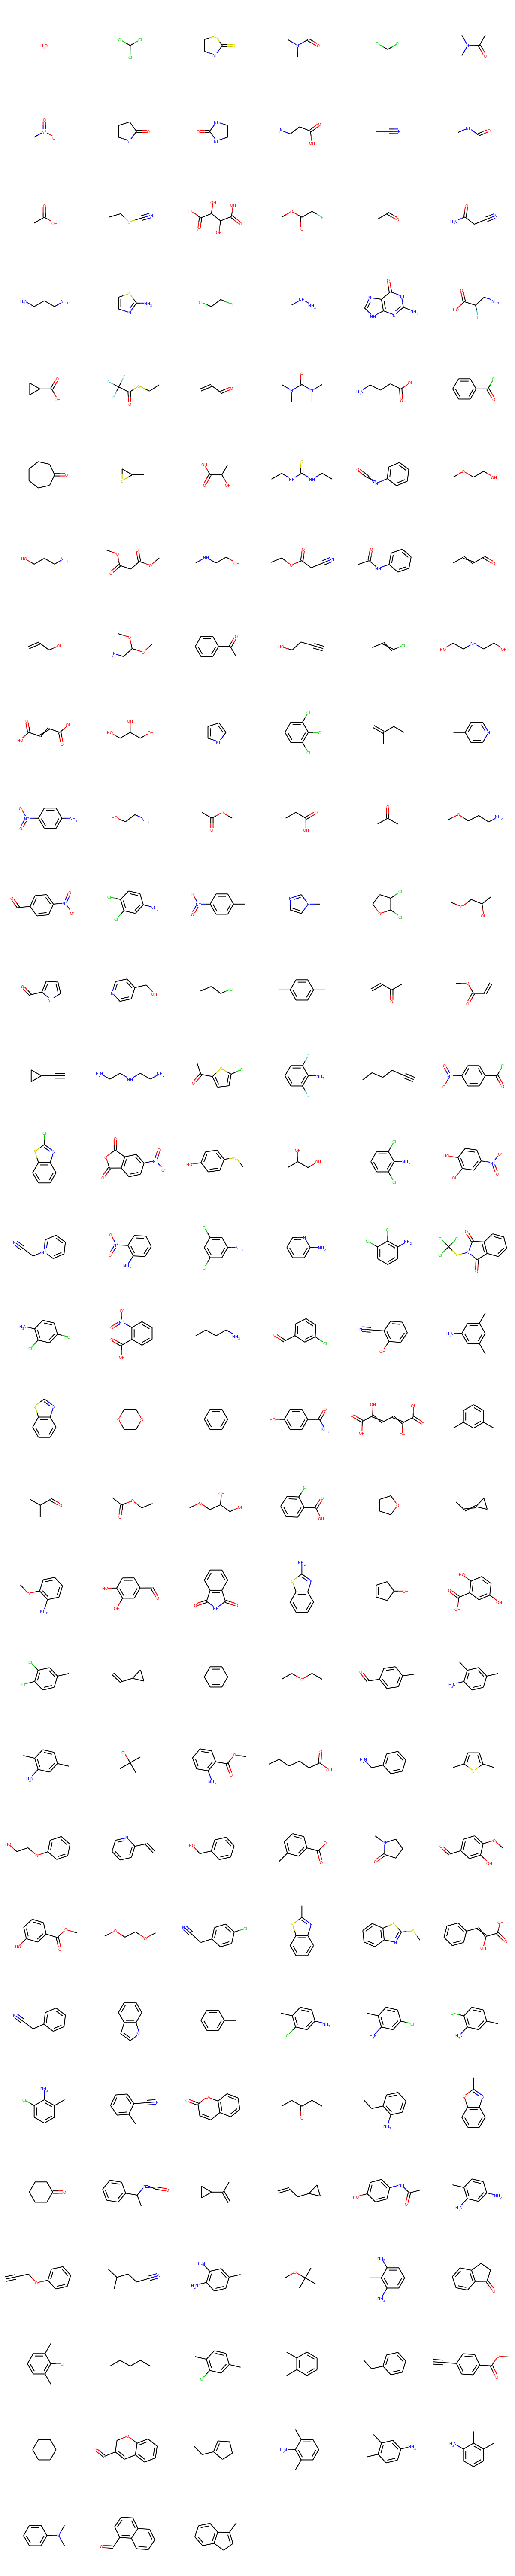

In [261]:
#from rdkit.Chem import Draw
#Draw.MolsToGridImage(list(mols_by_observed_nuc.rdmol_plot), molsPerRow=6)